In [ ]:
import os

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random

import logging
import time
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/boilers_drive/normalized_df.csv'

Mounted at /content/drive


In [ ]:
# Read the CSV file
data = pd.read_csv(file_path)

#print("Imported data:")
#print(data)

**Preparing the data**

In [ ]:
# the categories for prediction
final_category = 'blr_mod_lvl'

In [ ]:
# Getting the trained model from saved file

# Paths for model and training history
path_to_file = '/content/drive/Othercomputers/My_Laptop/code/models/'
model_name = 'transformer_blr_only_1_house(home13)'
path_to_saved_model = path_to_file + model_name
path_to_history = path_to_file + model_name + '_history.pkl'

# Loading from store
model = tf.keras.models.load_model(path_to_saved_model)
with open(path_to_history, 'rb') as f:
    history = pickle.load(f)

In [ ]:
print(model.summary())
print(history)

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  0         
                                                                 
 encoder (Encoder)           multiple                  398976    
                                                                 
 decoder (Decoder)           multiple                  664960    
                                                                 
 dense_19 (Dense)            multiple                  65        
                                                                 
Total params: 1064001 (4.06 MB)
Trainable params: 1064001 (4.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
{'loss': [0.08503686636686325, 0.011719604954123497, 0.011297181248664856, 0.011061874218285084, 0.01094738207757473, 0.010865637101233006, 0.01

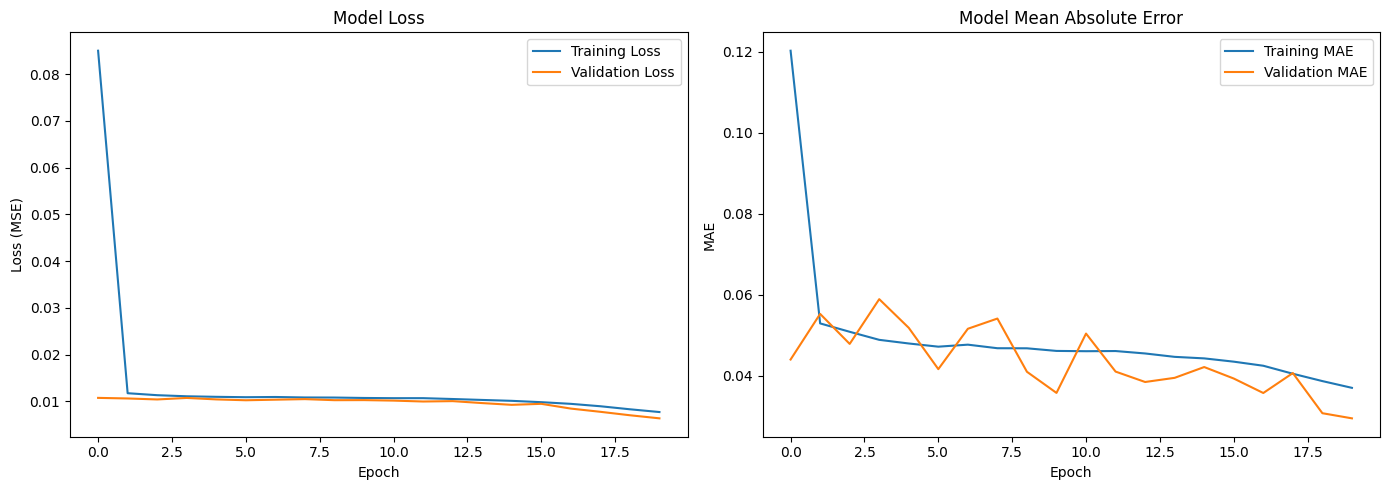

In [ ]:
# Plotting the training and validation loss and MAE
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history['mean_absolute_error'], label='Training MAE')
plt.plot(history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_dataset, return_dict=True)
#print(f"Test Loss (MSE): {test_results['loss']}, Test MAE: {test_results['mean_absolute_error']}")

# model.predict() !!! (not model.evaluate)

148/148 [==============================] - 33s 222ms/step - loss: 0.0068 - mean_absolute_error: 0.0314


In [ ]:
test_predictions = model.predict(test_dataset)

148/148 [==============================] - 34s 219ms/step


In [ ]:
#print(test_predictions.shape)
#flattened_predictions = test_predictions.reshape(-1)
#print(flattened_predictions.shape)
#print(flattened_predictions)
#de_scaled_predictions = de_scale(flattened_predictions.reshape(-1, 1), 'blr_mod_lvl')
#print(de_scaled_predictions)

# we get the predictions that correspond to the target_test

#print(target_test.shape)
#flattened_target = target_test.reshape(-1)
#print(flattened_target)
#de_scaled_target = de_scale(flattened_target.reshape(-1, 1), 'blr_mod_lvl')
#print(de_scaled_target)

In [ ]:
def get_test_values(test_values):
  flattened_test_values = test_values.reshape(-1)
  de_scaled_test_values = de_scale(flattened_test_values.reshape(-1, 1), 'blr_mod_lvl')
  final_test_values = de_scaled_test_values.reshape(-1)
  return final_test_values

In [ ]:
# function which randomly selects one day from the original prediction results
def get_random_day(predictions, target):
  random_day_index = random.randint(0, predictions.shape[0] - 1)
  selected_day_prediction = predictions[random_day_index]
  selected_day_target = target[random_day_index]
  selected_day_prediction_final = get_test_values(selected_day_prediction)
  selected_day_target_final = get_test_values(selected_day_target)
  return selected_day_prediction_final, selected_day_target_final

In [ ]:
random_day_prediction, random_day_target = get_random_day(test_predictions, target_test)
print("Random Day Prediction:", random_day_prediction)
print("Random Day Target:", random_day_target)

Random Day Prediction: [ 5.0322704  4.8768334  4.7818475 ... -1.0015002 -1.141188  -1.2381945]
Random Day Target: [19.89303692 18.42637647 14.67591764 ...  1.84059946  1.2270663
  0.8180442 ]


In [ ]:
# function that gives us the error metrics for given pair target, prediction
def get_error_metrics(target, prediction):
  # error values
  error = [t - p for t, p in zip(target, prediction)]
  AE = [abs(e) for e in error] # Absolute Error
  SE = [e ** 2 for e in error] # Squared Error
  APE = [abs((t - p) / t) for t, p in zip(target, prediction)] # Absolute Percentage Error

  # error metrics
  # Mean Absolute Error, gives magnitude of errors without caring for direction
  MAE = np.mean(AE)
  # Mean Squared Error, gives higher weight for larger errors
  MSE = np.mean(SE)
  # Root Mean Squared Error,  it is in the same units as the target variable
  RMSE = np.sqrt(MSE)
  # Mean Absolute Percentage Error, provides a perspective on the size of the error relative to the target values (given as percentage %)
  MAPE = np.mean(APE) * 100
  # R-Squared, statistical measure that represents the proportion of the variance for the target variable that's explained by the model
  # provides an indication of the goodness of fit
  mean_target = np.mean(target)
  diff = [t - mean_target for t in target]
  denominator = [d ** 2 for d in diff]
  R2 = 1 - (sum(SE) / sum(denominator))

  # minimum and maximum errors and values
  minimum_error = np.min(error)
  maximum_error = np.max(error)
  min_pred = np.min(prediction)
  max_pred = np.max(prediction)
  min_target = np.min(target)
  max_target = np.max(target)

  errors = pd.DataFrame({
      'blr_mod_lvl': target,
      'prediction': prediction,
      'error': error,
      'AE': AE,
      'SE': SE,
      'APE': APE
  })

  errors['MAE'] = MAE
  errors['MSE'] = MSE
  errors['RMSE'] = RMSE
  errors['MAPE'] = MAPE
  errors['R2'] = R2
  errors['minimum_error'] = minimum_error
  errors['maximum_error'] = maximum_error
  errors['minimum_prediction'] = min_pred
  errors['maximum_prediction'] = max_pred
  errors['minimum_target'] = min_target
  errors['maximum_target'] = max_target

  return errors


In [ ]:
target = get_test_values(target_test)
prediction = get_test_values(test_predictions)

errors = get_error_metrics(target, prediction)

print("\n Table with errors")
print(errors)

<ipython-input-38-470568afdeb7>:7: RuntimeWarning: divide by zero encountered in scalar divide
  APE = [abs((t - p) / t) for t, p in zip(target, prediction)] # Absolute Percentage Error
<ipython-input-38-470568afdeb7>:7: RuntimeWarning: overflow encountered in scalar divide
  APE = [abs((t - p) / t) for t, p in zip(target, prediction)] # Absolute Percentage Error
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



 Table with errors
          blr_mod_lvl  prediction     error        AE        SE           APE  \
0        2.048427e-08    0.171338 -0.171338  0.171338  0.029357  8.364362e+06   
1        1.365618e-08    0.158856 -0.158856  0.158856  0.025235  1.163255e+07   
2        9.104121e-09    0.166520 -0.166520  0.166520  0.027729  1.829066e+07   
3        6.069414e-09    0.190216 -0.190216  0.190216  0.036182  3.134002e+07   
4        4.046276e-09    0.202335 -0.202335  0.202335  0.040939  5.000519e+07   
...               ...         ...       ...       ...       ...           ...   
1702075  6.794076e-19    0.520067 -0.520067  0.520067  0.270470  7.654714e+17   
1702076  4.529384e-19    0.500196 -0.500196  0.500196  0.250196  1.104336e+18   
1702077  3.019589e-19    0.486260 -0.486260  0.486260  0.236449  1.610352e+18   
1702078  2.013060e-19    0.461625 -0.461625  0.461625  0.213097  2.293150e+18   
1702079  1.342040e-19    0.394146 -0.394146  0.394146  0.155351  2.936917e+18   

       

In [ ]:
# Now the errors, error metrics for the random day
errors_day = get_error_metrics(random_day_target, random_day_prediction)

print("\n Table with errors for random day")
print(errors_day)


 Table with errors for random day
      blr_mod_lvl  prediction      error         AE          SE       APE  \
0       19.893037    5.032270  14.860766  14.860766  220.842381  0.747034   
1       18.426376    4.876833  13.549543  13.549543  183.590116  0.735334   
2       14.675918    4.781847   9.894070   9.894070   97.892624  0.674170   
3       10.114501    4.724797   5.389704   5.389704   29.048908  0.532869   
4        6.743000    4.799429   1.943571   1.943571    3.777470  0.288235   
...           ...         ...        ...        ...         ...       ...   
1435     4.141349   -0.665097   4.806446   4.806446   23.101924  1.160599   
1436     2.760899   -0.907946   3.668845   3.668845   13.460422  1.328859   
1437     1.840599   -1.001500   2.842100   2.842100    8.077531  1.544116   
1438     1.227066   -1.141188   2.368254   2.368254    5.608629  1.930013   
1439     0.818044   -1.238194   2.056239   2.056239    4.228117  2.513603   

           MAE       MSE       RMSE  MAP

<ipython-input-38-470568afdeb7>:7: RuntimeWarning: divide by zero encountered in scalar divide
  APE = [abs((t - p) / t) for t, p in zip(target, prediction)] # Absolute Percentage Error


In [ ]:
# get plots with the error metrics
def plot_error_metrics(errors):
    plt.figure(figsize=(14, 10))
    # we will make n plots
    ploting_items = errors
    plot_list = [['blr_mod_lvl', 'prediction', 'minimum_prediction', 'maximum_prediction', 'minimum_target', 'maximum_target'],
                  ['error', 'minimum_error', 'maximum_error'], ['AE', 'MAE', 'RMSE'], ['SE', 'MSE']]
    n = len(plot_list)
    for i in range(n):
        to_plot = plot_list[i]
        plt.subplot(1, n+1, i)
        for j in range(1, len(to_plot)+1):
            to_plot_name = to_plot[j-1]
            plt.plot(ploting_items[to_plot_name], label=to_plot_name)
        #plt.title()
        plt.xlabel('Time')
        #plt.ylabel()
        plt.legend(loc='upper right')